In [ ]:
#!pip install pyspark
#!pip install numpy
#!pip install pandas
#!pip install sklearn
#!pip install numpy cython
#!pip install scipy --no-cache-dir
#!pip install wheel
#!brew install libomp
#!pip install lightgbm

In [1]:
#from google.colab import drive
import numpy as np
import pandas as pd
import re
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from time import time
import pickle
import scipy.sparse as sp
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from scipy.sparse import hstack

In [9]:
df = pd.read_csv('convincing_data.csv')

In [44]:
####################################################################################################
# sentiment score 0.33
def sentimentClassify(sentiment_label):
    if sentiment_label > 1/3:
        return 1
    elif sentiment_label < -1/3:
        return -1
    else:
        return 0
comments = df['body_cleaned']
others = df[['score','body_length']]
df['sentiment_tri'] = df['sentiment'].apply(sentimentClassify)

y1 = df['sentiment_tri']

In [46]:
####################################################################################################
# sentiment score 0.5
def map_sentiment_label(sentiment_label):
    if sentiment_label > 0.5:
        return 1
    elif sentiment_label < -0.5:
        return -1
    else:
        return 0

y2 = df['sentiment'].apply(map_sentiment_label)


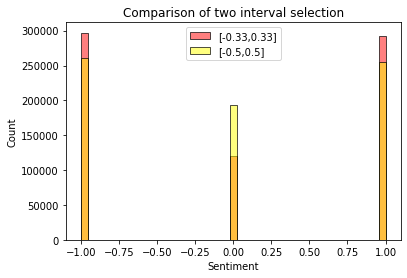

In [47]:
import matplotlib.pyplot as plt
# histogram plot
sns.histplot(data=y1, color='red', label='[-0.33,0.33]', alpha=0.5)
sns.histplot(data=y2, color='yellow', label='[-0.5,0.5]', alpha=0.5)
#sns.histplot(data=y1, color='red', label='[-0.33,0.33]', alpha=1)

# set attributes
plt.title('Comparison of two interval selection')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend()

# show
plt.show()

In [48]:
#########################
# process comments so that we can calculate tf-idf
comments = df['body_cleaned']
words_list = comments.apply(lambda x:re.split(r"[\[,'\]\s]+", x)[1:])
wordslist = words_list.apply(lambda x: ' '.join(x))

In [49]:
df['words_list'] = wordslist
Dataset = df[['words_list','score','body_length','sentiment_tri']]
#Dataset.to_csv('DataSet.csv')

In [69]:
#########################
# calculate tf-idf
#tfidf_vectorizer = TfidfVectorizer(max_features = 1000)
tfidf_vectorizer = TfidfVectorizer()
vec_comments = tfidf_vectorizer.fit_transform(df['words_list'])

#cnt_vectorizer = CountVectorizer()
#vec_cnt_comments = cnt_vectorizer.fit_transform(df['words_list'])

In [78]:
X_with_attrs = vec_comments
#X_with_attrs = vec_cnt_comments

In [72]:
#Y = pd.read_csv('DataSet_Y.csv',index_col=0)
Y = Dataset['sentiment_tri']

In [80]:
#########################
# split data `set
X_train, X_test, y_train, y_test = train_test_split(X_with_attrs, Y, test_size=0.2, random_state=42)

In [68]:
X_train

array([[ 1.41095440e+03, -1.67999705e+01,  2.47527741e+00, ...,
         1.15970210e-01,  2.93221561e-02, -7.50627723e-02],
       [ 3.20519850e+03,  3.15484177e+01, -2.75280729e+00, ...,
         5.57168974e-02, -3.77880817e-01, -8.94080028e-01],
       [ 1.31980920e+02, -5.63415035e+00,  2.37994196e+00, ...,
        -7.12145294e-03, -3.40381635e-03, -1.52215367e-02],
       ...,
       [ 3.04025737e+02,  2.53639176e+00,  2.08154474e+00, ...,
         1.72514981e-02, -6.29835577e-02,  4.47172769e-02],
       [ 2.78000655e+03, -1.23978248e+01,  3.80203879e+00, ...,
        -5.25679114e-01,  1.03768571e-01,  1.17288820e-01],
       [ 5.81007784e+02, -1.79900470e+00,  2.06648037e+00, ...,
         8.20904193e-02, -4.82328743e-01, -1.59219712e-01]])

In [81]:
from lightgbm import LGBMClassifier
lgbm_clf=LGBMClassifier(boosting_type='gbdt', class_weight=None, 
               learning_rate=0.1, max_depth=6, n_estimators=300, 
               reg_alpha=0.0, reg_lambda=0.0,
               colsample_bytree=1.0, subsample=1.0,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0, num_leaves=100,
               n_jobs=-1, objective='multiclass', importance_type='split',
               random_state=42)
lgbm_clf.fit(X_train,y_train)
lgbm_y_pred = lgbm_clf.predict(X_test)
print(classification_report(y_test, lgbm_y_pred))

#print('Training accuracy {:.4f}'.format(lgbm_clf.score(X_train,y_train)))

print('Testing accuracy {:.4f}'.format(lgbm_clf.score(X_test,y_test)))

              precision    recall  f1-score   support

          -1       0.68      0.76      0.71     59343
           0       0.53      0.23      0.32     24013
           1       0.68      0.76      0.72     58492

    accuracy                           0.67    141848
   macro avg       0.63      0.58      0.58    141848
weighted avg       0.65      0.67      0.65    141848

Testing accuracy 0.6677


In [82]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.fit_transform(X_test)
MlNB_clf = MultinomialNB()
MlNB_clf.fit(scaled_X_train, y_train)

MlNB_y_pred = MlNB_clf.predict(scaled_X_test)

print(classification_report(y_test, MlNB_y_pred))
print('Testing accuracy {:.4f}'.format(MlNB_clf.score(scaled_X_test,y_test)))

Testing accuracy 0.4455
              precision    recall  f1-score   support

          -1       0.43      0.91      0.58     59343
           0       0.00      0.00      0.00     24013
           1       0.62      0.15      0.24     58492

    accuracy                           0.45    141848
   macro avg       0.35      0.36      0.28    141848
weighted avg       0.43      0.45      0.34    141848



/Users/liangxin/miniconda3/envs/foo/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liangxin/miniconda3/envs/foo/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liangxin/miniconda3/envs/foo/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r